In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Read in data
words = open('names.txt', 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
c_to_i = {c: i+1 for i, c in enumerate(chars)}
c_to_i['.'] = 0
i_to_c = {i: c for c, i in c_to_i.items()}

In [4]:
# Number of inputs prior to target character
BLOCK_SIZE = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE

        for ch in w + '.':
            target_idx = c_to_i[ch]
            X.append(context)
            Y.append(target_idx)

            # Slide context window over to next set of chars
            context = context[1:] + [target_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
# Instantitate generator
g = torch.Generator().manual_seed(2147483647)

# Set hyper parameters
EMBEDDING_DIM = 10
INPUT_DIM = BLOCK_SIZE * EMBEDDING_DIM
HIDDEN_DIM = 200

# Create embedding matrix
C = torch.randn((27, EMBEDDING_DIM), generator=g)

# Create weight_1 & bias_1
W1 = torch.randn((INPUT_DIM, HIDDEN_DIM), generator=g)
b1 = torch.randn(HIDDEN_DIM, generator=g)

# Create weight_2 & bias_2
OUTPUT_DIM = 27 # alphabet size
W2 = torch.randn((HIDDEN_DIM, OUTPUT_DIM), generator=g)
b2 = torch.randn(OUTPUT_DIM, generator=g)

# Require gradients
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [16]:
sum(p.nelement() for p in parameters)

11897

In [17]:
def forward_pass(xs):
    embedding = C[xs]
    h = torch.tanh(embedding.view(-1, INPUT_DIM) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

In [18]:
def compute_loss(logits, ys):
    loss = F.cross_entropy(logits, ys)
    return loss

In [19]:
def backward_pass(loss, lr=0.1):
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -lr * p.grad
    return None

In [20]:
def train_one_iteration(x_batch, y_batch, lr):
    logits = forward_pass(x_batch)
    loss = compute_loss(logits, y_batch)
    _ = backward_pass(loss, lr=lr)
    return loss

In [21]:
def find_learning_rate(min_exp, max_exp, steps, batch_size):
    exps = torch.linspace(min_exp, max_exp, steps)
    lrs = 10 ** exps

    lr_i = []
    loss_i = []
    for i in range(steps):
        ixs = torch.randint(0, X_train.shape[0], (batch_size,))
        x_batch = X_train[ixs]
        y_batch = Y_train[ixs]

        batch_loss = train_one_iteration(x_batch, y_batch, lrs[i])
        lr_i.append(lrs[i])
        loss_i.append(batch_loss.item())

    plt.plot(lr_i, loss_i)

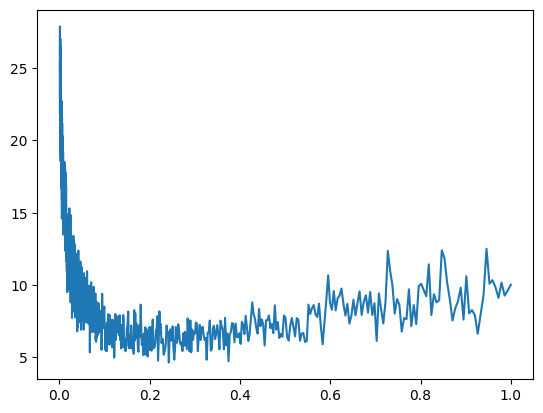

In [12]:
find_learning_rate(-3, 0, 1000, 64)

In [22]:
losses = []

In [23]:
# Training loop
n_iter = 10000
batch_size = 64
lr = 0.001

for i in range(n_iter):
    # minibatching
    ixs = torch.randint(0, X_train.shape[0], (batch_size,))
    x_batch = X_train[ixs]
    y_batch = Y_train[ixs]

    batch_loss = train_one_iteration(x_batch, y_batch, lr)
    if i % 1000 == 0:
        print(batch_loss)
    losses.append(batch_loss.item())

tensor(23.1088, grad_fn=<NllLossBackward0>)
tensor(18.1842, grad_fn=<NllLossBackward0>)
tensor(15.7303, grad_fn=<NllLossBackward0>)
tensor(10.0773, grad_fn=<NllLossBackward0>)
tensor(9.7522, grad_fn=<NllLossBackward0>)
tensor(10.2749, grad_fn=<NllLossBackward0>)
tensor(8.7365, grad_fn=<NllLossBackward0>)
tensor(7.5139, grad_fn=<NllLossBackward0>)
tensor(8.6580, grad_fn=<NllLossBackward0>)
tensor(8.0795, grad_fn=<NllLossBackward0>)


In [24]:
# Evaluate on full training set
logits = forward_pass(X_train)
loss = compute_loss(logits, Y_train)
print(loss)

tensor(7.8496, grad_fn=<NllLossBackward0>)


In [25]:
# Evaluate on full validation set
logits = forward_pass(X_val)
loss = compute_loss(logits, Y_val)
print(loss)

tensor(7.8156, grad_fn=<NllLossBackward0>)


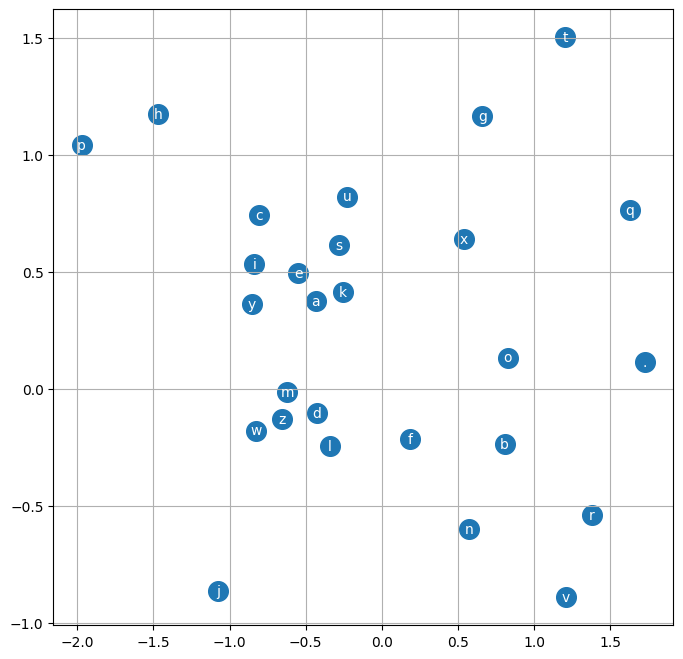

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), i_to_c[i], ha='center', va='center', color='white')
plt.grid('minor')

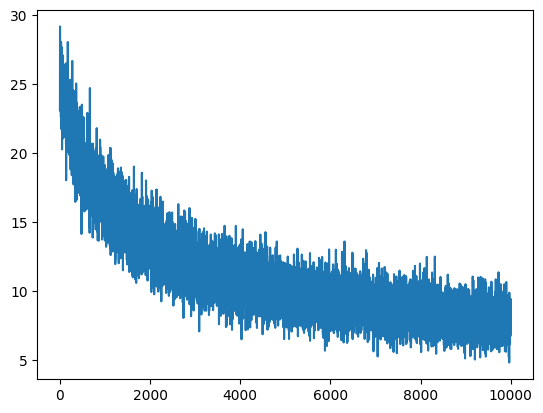

In [27]:
plt.plot(range(len(losses)), losses)

In [28]:
# Generate names
def generate_names(n, generator=None):
    if generator is None:
        generator = torch.Generator().manual_seed(2147483647)
    
    for _ in range(n):
        out = []

        context = [0] * BLOCK_SIZE
        while True:
            emb = C[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        
        print(''.join(i_to_c[i] for i in out))

In [29]:
generate_names(20, torch.Generator().manual_seed(2147483647 + 10))

card.
hfleojrigi.
ker.
shrleaya.
kanslkhrone.
bra.
mwothxfilah.
coenitea.
condikahlie.
gal.
bry.
kanslyh.
tha.
lekahliioenieaanrruatzadiyn.
kauaadrrntesjrhgler.
gal.
leayaria.
ramaillonn.
yalie.
bwies.
